In [36]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import seaborn as sns

from src.data.Preprocess import extend_market_data

# Getting and preprocessing the data

In [37]:
SRW = yf.Ticker("ZW=F")
SRW_data = SRW.history(start ="2014-01-01").drop(['Dividends', 'Stock Splits'], axis=1)
SRW_data = extend_market_data(SRW_data)
SRW_data['Target'] = SRW_data['Log_Return'].shift(-1)
SRW_data.dropna(inplace=True)
SRW_data.head()

,Open,High,Low,Close,Volume,Year,Month,Day,Day_Of_Year,expiry,...,Low-Close,TR,14D_ATR,Volume_Volatility_Ratio,14D_RSI,7D_MA,14D_MA,7D_EMA,14D_EMA,Target
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-23,561.75,578.00,561.50,570.00,47326,2014,1,23,23,2014-03-14,...,0.25,16.75,12.517857,3.391011e+06,35.405405,568.107143,579.017857,569.022517,575.619286,-0.008368
2014-01-24,571.00,573.50,562.50,565.25,39689,2014,1,24,24,2014-03-14,...,7.50,11.00,12.375000,3.049951e+06,27.118644,566.107143,576.125000,568.079388,574.236715,-0.003101
2014-01-27,567.00,572.25,562.75,563.50,44294,2014,1,27,27,2014-03-14,...,2.50,9.50,12.500000,3.420749e+06,26.592798,565.500000,573.107143,566.934541,572.805153,0.004427
2014-01-28,564.00,569.00,564.00,566.00,44179,2014,1,28,28,2014-03-14,...,0.50,5.50,12.303571,3.347173e+06,29.608939,564.535714,570.500000,566.700906,571.897799,-0.025952
2014-01-29,567.00,567.00,550.50,551.50,84576,2014,1,29,29,2014-03-14,...,15.50,16.50,12.017857,6.251879e+06,29.362881,562.821429,567.839286,562.900679,569.178092,0.003620


# Defining the feature columns and the train test split

In [38]:
feature_cols = ['Close', 'Volume', 'Day_Of_Year', 'Year', 'Month', 'Day' ,'DTE', '7D_Volatility', '14D_ATR', '7D_MA', '7D_EMA', '14D_RSI']
splitting_point = '2025-01-01'

scaler = StandardScaler()

X_test_pd = SRW_data[SRW_data.index >= splitting_point][feature_cols]
y_test = SRW_data[SRW_data.index >= splitting_point]['Target']
X_train_pd = SRW_data[SRW_data.index < splitting_point][feature_cols]
y_train = SRW_data[SRW_data.index < splitting_point]['Target']

X_train = scaler.fit_transform(X_train_pd)
X_test = scaler.transform(X_test_pd)

# Linear regression model with CV

Cross-validation R^2 scores on the training set: [-0.01562987 -0.221459   -0.11861645 -0.00773133 -0.01307229]
Average R^2 score: -0.0753
The R^2 score on the testing set: -0.0077


<Axes: title={'center': 'The Linear Regression Model on the training set'}, xlabel='Date', ylabel='Target'>

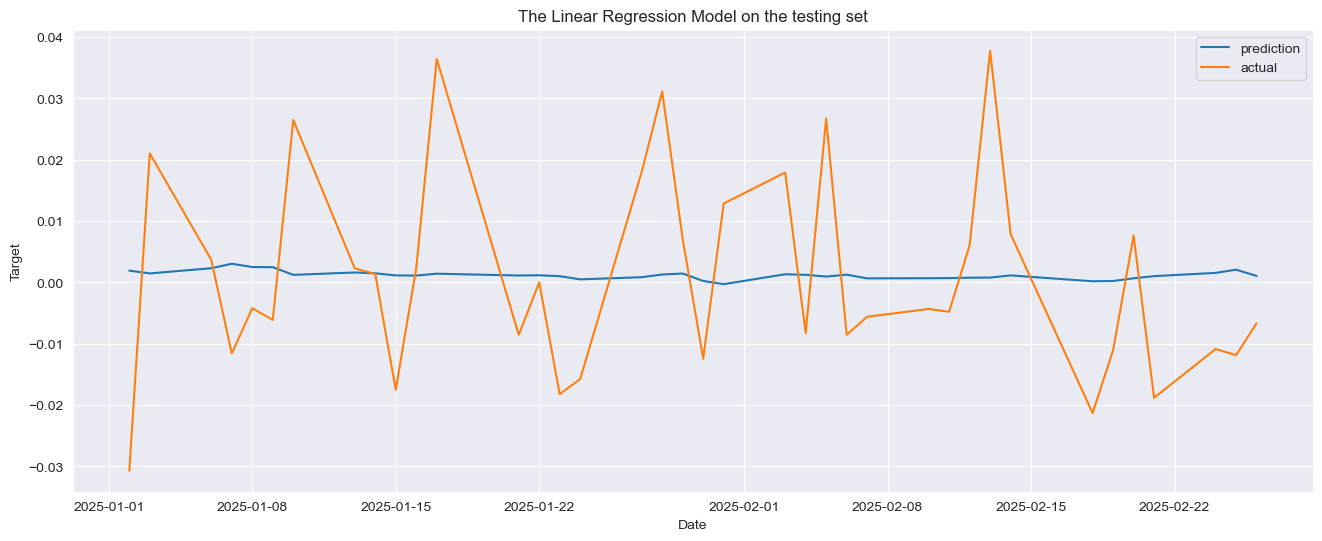

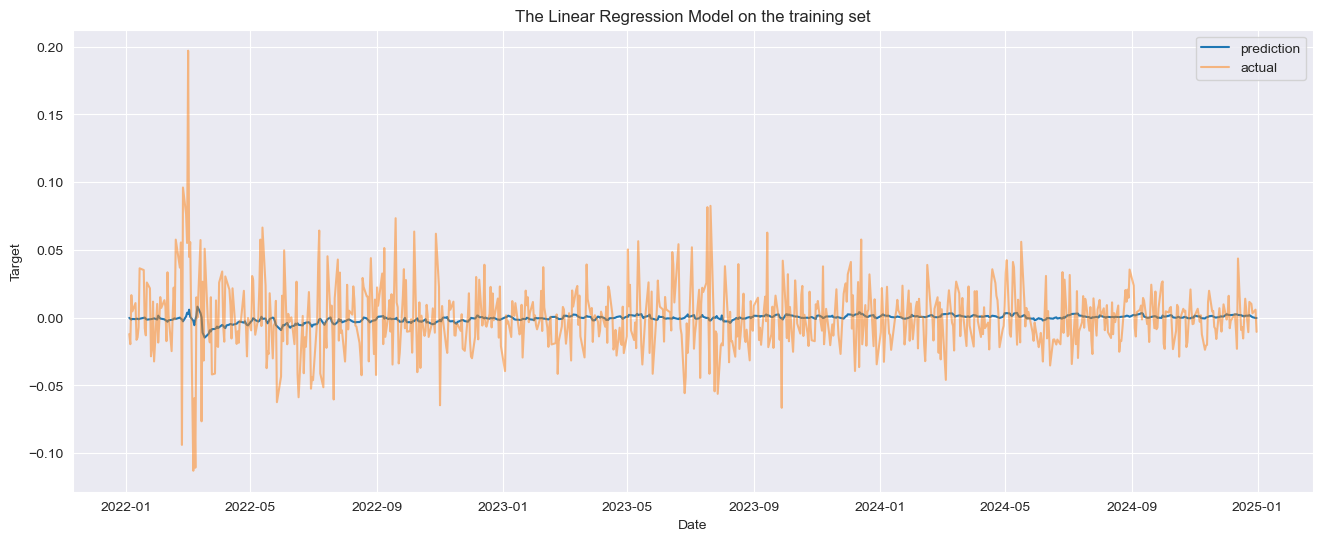

In [39]:
tscv = TimeSeriesSplit(n_splits=5)
model = LinearRegression()

cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
print(f'Cross-validation R^2 scores on the training set: {cv_scores}')
print(f'Average R^2 score: {np.mean(cv_scores):.4f}')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"The R^2 score on the testing set: {r2_score(y_test, y_pred):.4f}")

plt.figure(figsize=(16, 6))
plt.title('The Linear Regression Model on the testing set')
sns.lineplot(x=y_test.index, y=y_pred, label='prediction')
sns.lineplot(x=y_test.index, y=y_test, label='actual')

plt.figure(figsize=(16, 6))
plt.title('The Linear Regression Model on the training set')
sns.lineplot(x=y_train[2000:].index, y=model.predict(X_train[2000:]), label='prediction')
sns.lineplot(x=y_train[2000:].index, y=y_train[2000:], label='actual', alpha = 0.5)

### Understanding the Feature Importance

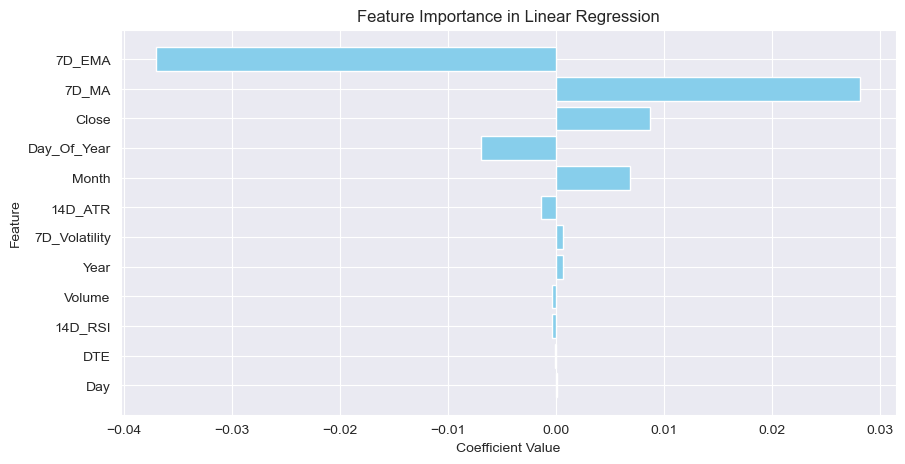

In [40]:
coefficients = model.coef_
coefficients_df = pd.DataFrame({"Feature": feature_cols, "Coefficient": coefficients}).sort_values(by="Coefficient", key=abs, ascending=False)
plt.figure(figsize=(10, 5))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Linear Regression')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

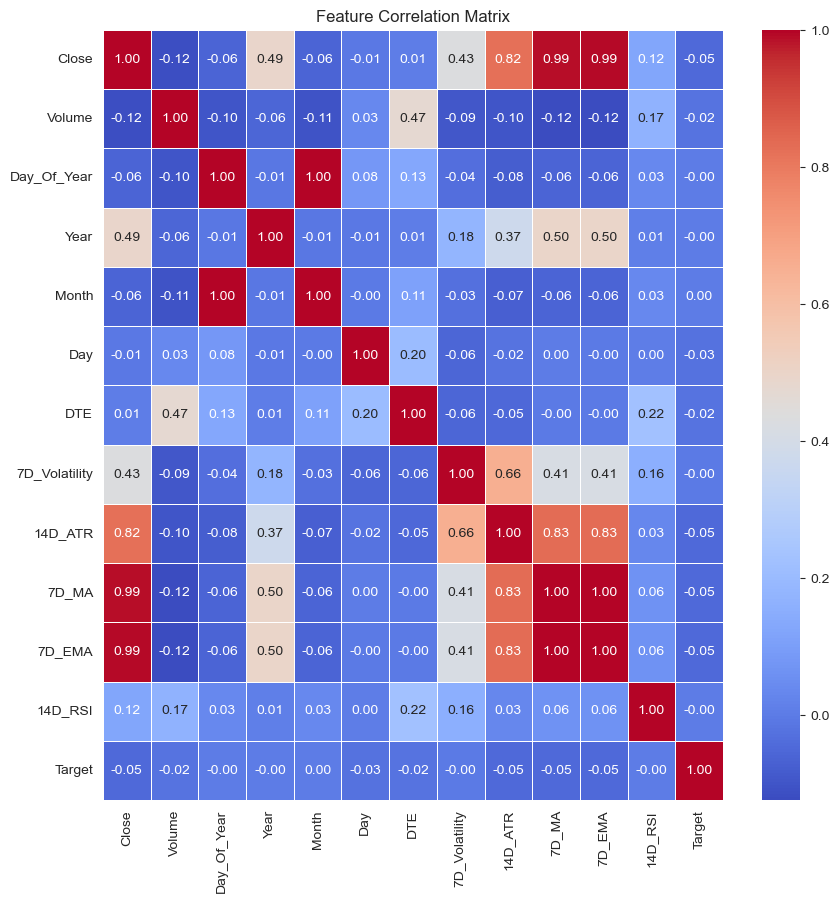

In [41]:
correlation_matrix = X_train_pd.merge(y_train, left_index=True, right_index=True).corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# Lasso regression on the market data

Cross-validation R^2 scores on the training set: [ 0.01228114 -0.03780136 -0.03885343  0.00536036 -0.0056159 ]
Average R^2 score: -0.0129
The Lasso Regression R^2 score on the testing set: -0.0043


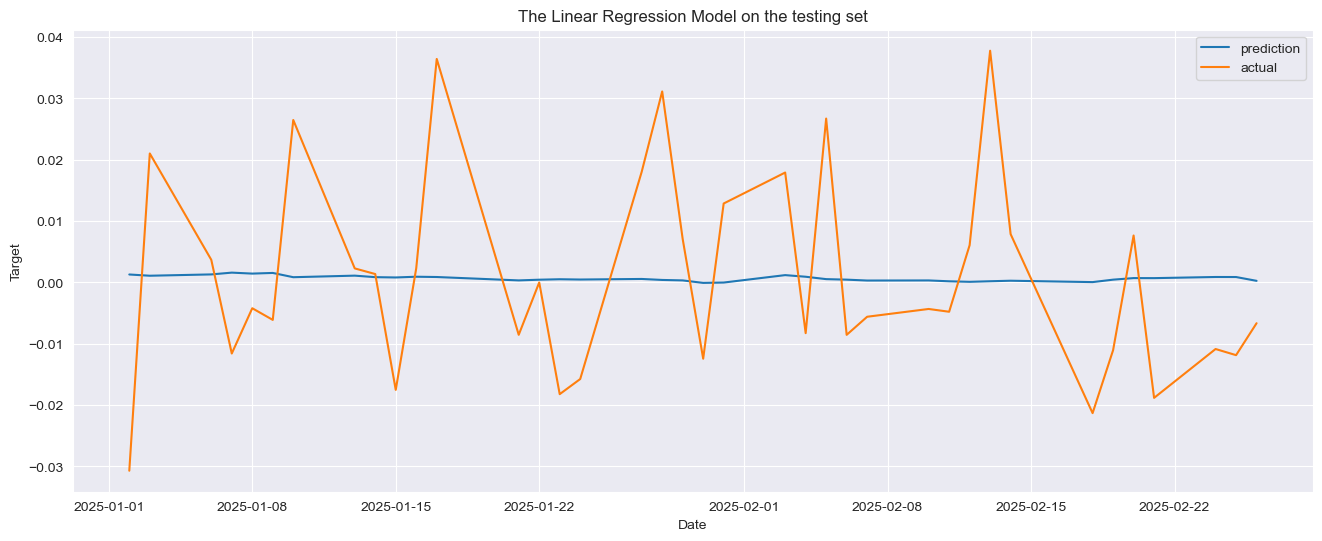

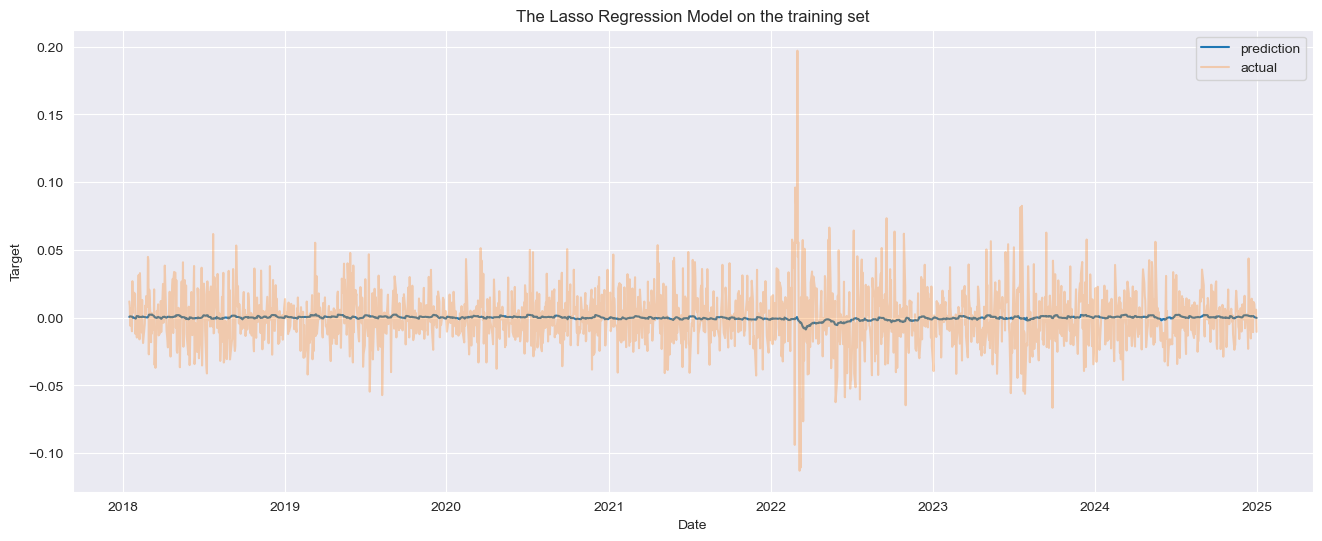

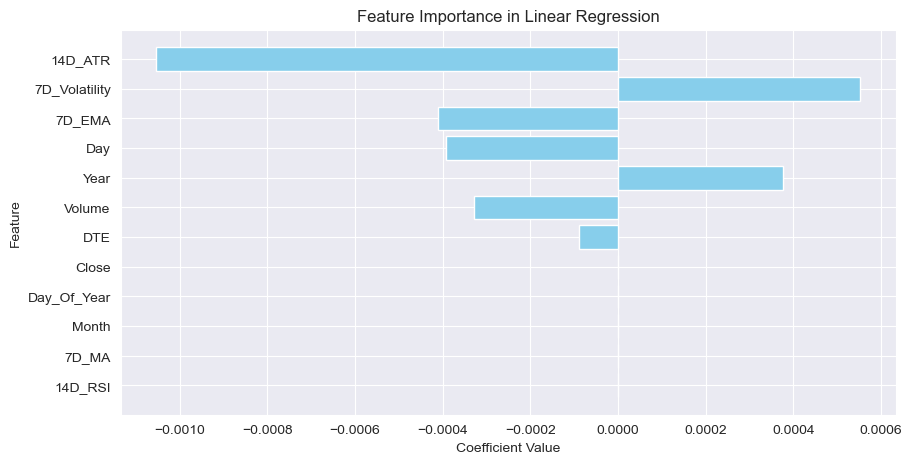

In [42]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=0.0001)
lasso_model.fit(X_train, y_train)

cv_scores = cross_val_score(lasso_model, X_train, y_train, cv=tscv, scoring='r2')
print(f'Cross-validation R^2 scores on the training set: {cv_scores}')
print(f'Average R^2 score: {np.mean(cv_scores):.4f}')

lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
print(f"The Lasso Regression R^2 score on the testing set: {r2_score(y_test, y_pred):.4f}")

plt.figure(figsize=(16, 6))
plt.title('The Linear Regression Model on the testing set')
sns.lineplot(x=y_test.index, y=y_pred, label='prediction')
sns.lineplot(x=y_test.index, y=y_test, label='actual')

plt.figure(figsize=(16, 6))
plt.title('The Lasso Regression Model on the training set')
sns.lineplot(x=y_train[1000:].index, y=lasso_model.predict(X_train[1000:]), label='prediction')
sns.lineplot(x=y_train[1000:].index, y=y_train[1000:], label='actual', alpha = 0.3)

coefficients = lasso_model.coef_
coefficients_df = pd.DataFrame({"Feature": feature_cols, "Coefficient": coefficients}).sort_values(by="Coefficient", key=abs, ascending=False)
plt.figure(figsize=(10, 5))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Linear Regression')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

## Linear regression model on the training set without 2022 data

Cross-validation R^2 scores on the training set: [-0.02996358 -0.3440984  -0.00460502 -0.07437484  0.00290585]
Average R^2 score: -0.0900
The R^2 score on the testing set: 0.0095


<Axes: title={'center': 'The Linear Regression Model on the training set'}, xlabel='Date', ylabel='Target'>

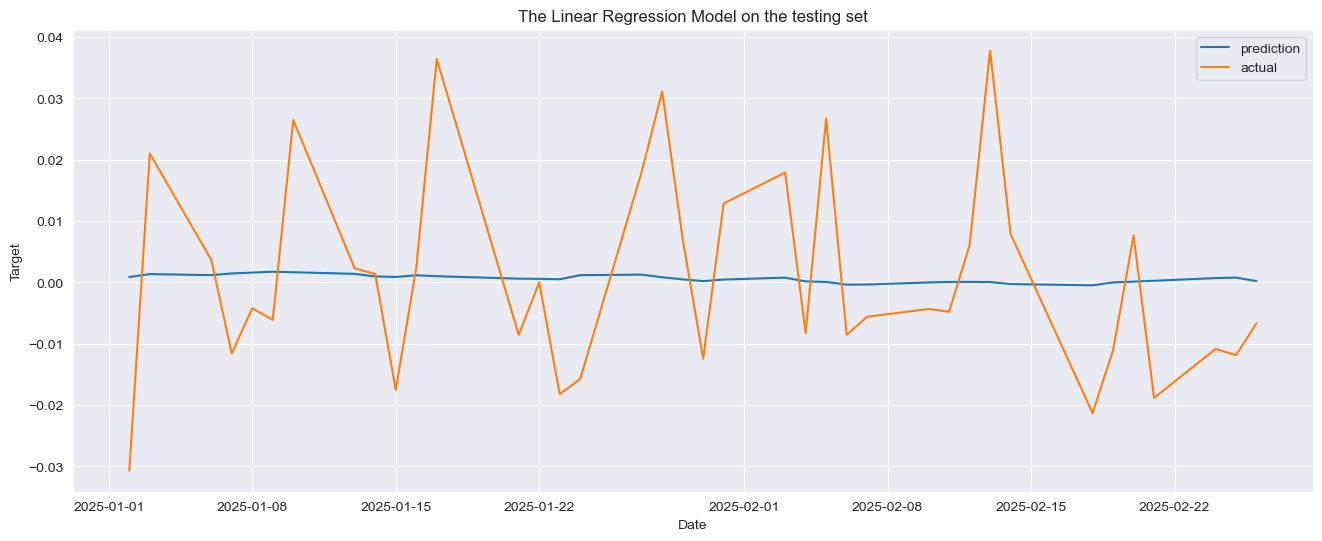

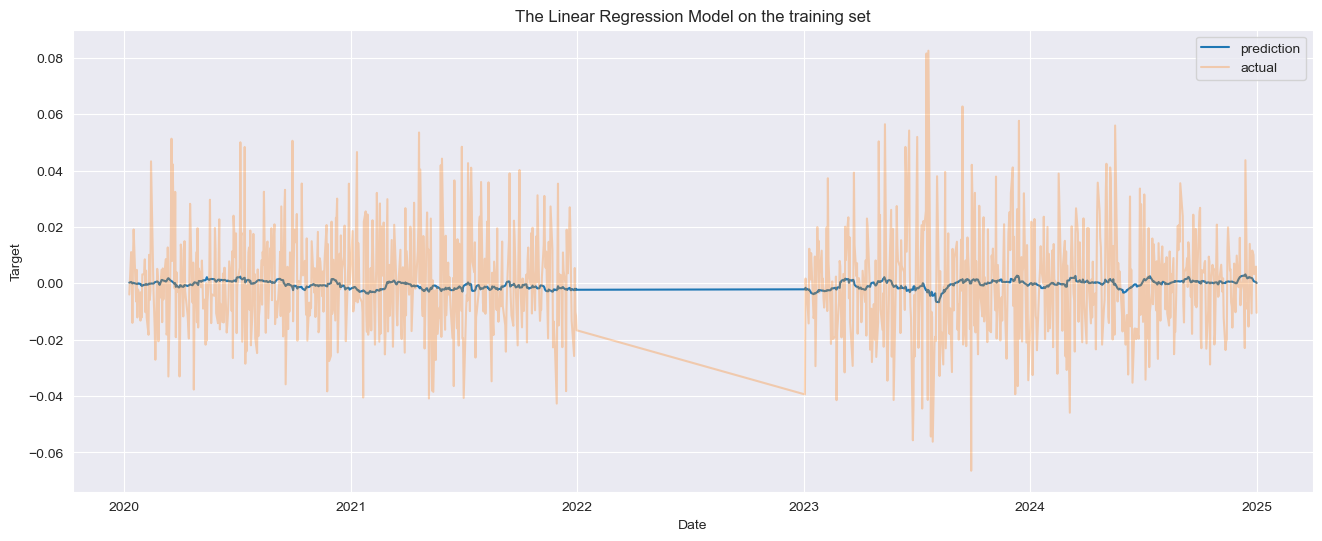

In [43]:
X_train_new = X_train_pd[X_train_pd.index.year != 2022]
y_train_new = y_train[X_train_pd.index.year != 2022]

X_train_new = scaler.fit_transform(X_train_new)
X_test = scaler.transform(X_test_pd)

tscv = TimeSeriesSplit(n_splits=5)
model = LinearRegression()

cv_scores = cross_val_score(model, X_train_new, y_train_new, cv=tscv, scoring='r2')
print(f'Cross-validation R^2 scores on the training set: {cv_scores}')
print(f'Average R^2 score: {np.mean(cv_scores):.4f}')

model.fit(X_train_new, y_train_new)
y_pred = model.predict(X_test)
print(f"The R^2 score on the testing set: {r2_score(y_test, y_pred):.4f}")

plt.figure(figsize=(16, 6))
plt.title('The Linear Regression Model on the testing set')
sns.lineplot(x=y_test.index, y=y_pred, label='prediction')
sns.lineplot(x=y_test.index, y=y_test, label='actual')

plt.figure(figsize=(16, 6))
plt.title('The Linear Regression Model on the training set')
sns.lineplot(x=y_train_new[1500:].index, y=model.predict(X_train_new[1500:]), label='prediction')
sns.lineplot(x=y_train_new[1500:].index, y=y_train_new[1500:], label='actual', alpha = 0.3)


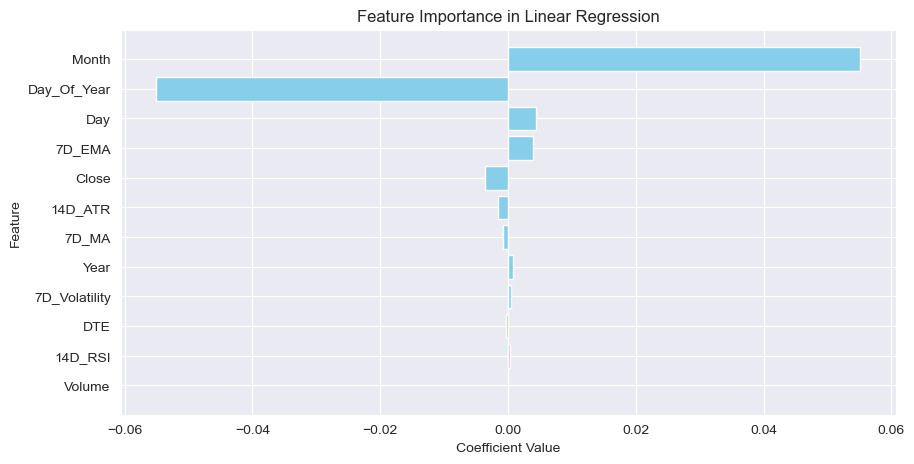

In [44]:
coefficients = model.coef_
coefficients_df = pd.DataFrame({"Feature": feature_cols, "Coefficient": coefficients}).sort_values(by="Coefficient", key=abs, ascending=False)
plt.figure(figsize=(10, 5))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Linear Regression')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# XGB Model with CV

In [61]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=3,
    eval_metric=r2_score,
#    device='cuda',
    reg_alpha=0.05,
    reg_lambda=0.1,
#    gamma=0.1,
#    early_stopping_rounds=250,
#    min_child_weight=5,
#    subsample=0.7,
#    colsample_bytree=0.7,
)

cv_scores = cross_val_score(xgb_model, X_train_new, y_train_new, cv=tscv, scoring='r2')
print(f'Cross-validation R2 scores: {-cv_scores}')  # Convert to positive MAE values
print(f'Average R2: {-np.mean(cv_scores):.4f}')

Cross-validation R2 scores: [0.49943856 0.15571369 0.16111439 0.2001546  0.01928548]
Average R2: 0.2071


[0]	validation_0-rmse:0.01975	validation_0-r2_score:0.00245	validation_1-rmse:0.01648	validation_1-r2_score:-0.00238
[50]	validation_0-rmse:0.01909	validation_0-r2_score:0.06746	validation_1-rmse:0.01652	validation_1-r2_score:-0.00697
[100]	validation_0-rmse:0.01875	validation_0-r2_score:0.10031	validation_1-rmse:0.01655	validation_1-r2_score:-0.01010
[150]	validation_0-rmse:0.01852	validation_0-r2_score:0.12278	validation_1-rmse:0.01654	validation_1-r2_score:-0.00929
[200]	validation_0-rmse:0.01834	validation_0-r2_score:0.13992	validation_1-rmse:0.01663	validation_1-r2_score:-0.02034
[250]	validation_0-rmse:0.01817	validation_0-r2_score:0.15558	validation_1-rmse:0.01666	validation_1-r2_score:-0.02395
[300]	validation_0-rmse:0.01797	validation_0-r2_score:0.17381	validation_1-rmse:0.01671	validation_1-r2_score:-0.02999
[350]	validation_0-rmse:0.01778	validation_0-r2_score:0.19162	validation_1-rmse:0.01672	validation_1-r2_score:-0.03085
[400]	validation_0-rmse:0.01763	validation_0-r2_sco

<Axes: title={'center': 'The Linear Regression Model on the training set'}, xlabel='Date', ylabel='Target'>

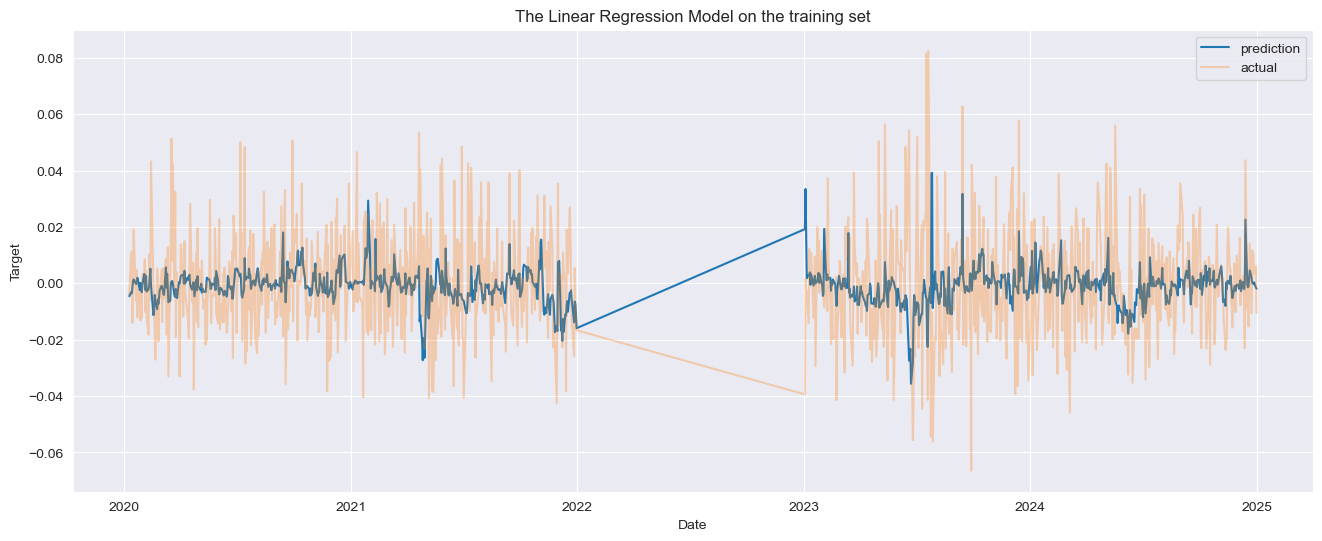

In [62]:
xgb_model.fit(X_train, y_train, verbose=50,eval_set=[(X_train, y_train), (X_test, y_test)])
y_pred = xgb_model.predict(X_test)

plt.figure(figsize=(16, 6))
plt.title('The Linear Regression Model on the training set')
sns.lineplot(x=y_train_new[1500:].index, y=xgb_model.predict(X_train_new[1500:]), label='prediction')
sns.lineplot(x=y_train_new[1500:].index, y=y_train_new[1500:], label='actual', alpha = 0.3)